# April 2025 — Phase 1 vs Phase 2 Anomaly Comparison (Updated Params)
Filters **only April 2025** transactions using the epoch window provided and compares **Phase 1** (`label`/`scoring`) vs **Phase 2** (`label_v2`/`scoring_v2`) on anomaly rate and descriptive statistics.

**Connection & Window:**
- `NEO4J_URI = bolt://192.168.0.5:7687`
- `auth = (neo4j, PotatoDTND12!)`
- Epoch window: `1743476400 ≤ timestamp < 1746068400` (2025‑04‑01 03:00:00 UTC to 2025‑05‑01 03:00:00 UTC)

**Data fields**
- Phase 1: `label` (0/1), `scoring` (float)
- Phase 2: `label_v2` (0/1), `scoring_v2` (float)


In [9]:
# --- Setup: Neo4j connection (using provided params) ---
# If needed on a clean environment: 
# !pip install neo4j pandas matplotlib

from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

NEO4J_URI = "bolt://192.168.0.5:7687"
NEO4J_USER = "neo4j"
NEO4J_PASS = "PotatoDTND12!"

# April 2025 window from user snippet (epoch seconds)
START_EPOCH = 1743476400   # 2025-04-01 03:00:00 UTC
END_EPOCH   = 1746068400   # 2025-05-01 03:00:00 UTC

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASS))

## Single Cypher query (April 2025 only, epoch filter)
We return one row per **phase × label** including descriptive stats on scores. Rows are constructed only when the relevant fields exist in the transaction.

In [10]:
cypher = r"""

// Use the epoch bounds provided by the user
MATCH (tx:Transaction)
WHERE tx.timestamp >= $startEpoch
  AND tx.timestamp <  $endEpoch

// Build rows for each phase if fields exist
WITH tx,
     CASE WHEN tx.label IS NOT NULL AND tx.scoring IS NOT NULL
          THEN {phase:'phase1', label: tx.label, score: toFloat(tx.scoring)} END AS r1,
     CASE WHEN tx.label_v2 IS NOT NULL AND tx.scoring_v2 IS NOT NULL
          THEN {phase:'phase2', label: tx.label_v2, score: toFloat(tx.scoring_v2)} END AS r2
WITH [r1, r2] AS rows
UNWIND rows AS r
WITH r WHERE r IS NOT NULL

RETURN
  r.phase          AS phase,
  r.label          AS label,        // 0=normal, 1=anomaly
  count(*)         AS n,
  avg(r.score)     AS mean_score,
  stDev(r.score)   AS std_score,
  min(r.score)     AS min_score,
  max(r.score)     AS max_score

"""

def run_query(q, params=None):
    with driver.session() as session:
        result = session.run(q, params or {})
        return pd.DataFrame([r.data() for r in result])

df = run_query(cypher, params={"startEpoch": START_EPOCH, "endEpoch": END_EPOCH})
print(f"Fetched {int(df['n'].sum()) if 'n' in df else 0} rows across groups")
df

Fetched 7350878 rows across groups


,phase,label,n,mean_score,std_score,min_score,max_score
0,phase1,0,3482586,0.233932,0.062097,2.851699e-06,2.864268e-01
1,phase2,0,3486388,0.211047,0.064093,5.361697e-07,2.693719e-01
2,phase1,1,192853,-0.044993,0.037662,-2.346918e-01,-7.530230e-07
3,phase2,1,189051,-0.032677,0.022936,-1.921282e-01,-4.825527e-06


## Compute totals, anomaly rate, and tidy tables

In [11]:
# Ensure numeric types for safety
for col in ["n", "mean_score", "std_score", "min_score", "max_score"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Totals per phase
totals = df.groupby("phase", as_index=False)["n"].sum().rename(columns={"n":"total"})

# Anomaly/normal breakdown
breakdown = df.pivot_table(index="phase", columns="label", values="n", aggfunc="sum").fillna(0).astype(int)
breakdown.columns = [f"label_{int(c)}" for c in breakdown.columns]
breakdown = breakdown.reset_index()

# Merge totals to compute anomaly rates
summary = breakdown.merge(totals, on="phase", how="left")
summary["anomaly_rate"] = summary.get("label_1", 0) / summary["total"]
summary = summary.sort_values("phase")
summary

,phase,label_0,label_1,total,anomaly_rate
0,phase1,3482586,192853,3675439,0.052471
1,phase2,3486388,189051,3675439,0.051436


### Descriptive stats by phase × label

In [12]:
stats = df.sort_values(["phase", "label"]).copy()
stats

,phase,label,n,mean_score,std_score,min_score,max_score
0,phase1,0,3482586,0.233932,0.062097,2.851699e-06,2.864268e-01
2,phase1,1,192853,-0.044993,0.037662,-2.346918e-01,-7.530230e-07
1,phase2,0,3486388,0.211047,0.064093,5.361697e-07,2.693719e-01
3,phase2,1,189051,-0.032677,0.022936,-1.921282e-01,-4.825527e-06


## Plots
1. **Anomaly rate by phase** (bar chart)
2. **Score distributions by phase** (violin)
3. **Per-label boxplots** inside each phase (optional)

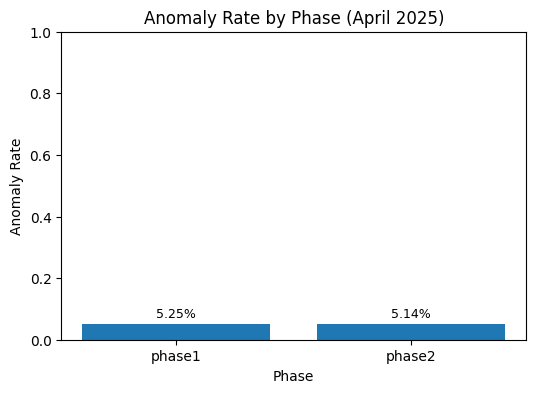

In [13]:
# 1) Anomaly rate bar chart
phases = summary["phase"].tolist()
rates  = summary["anomaly_rate"].tolist()

plt.figure(figsize=(6,4))
plt.bar(phases, rates)
plt.title("Anomaly Rate by Phase (April 2025)")
plt.ylabel("Anomaly Rate")
plt.xlabel("Phase")
plt.ylim(0, 1)
for i, v in enumerate(rates):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=9)
plt.show()

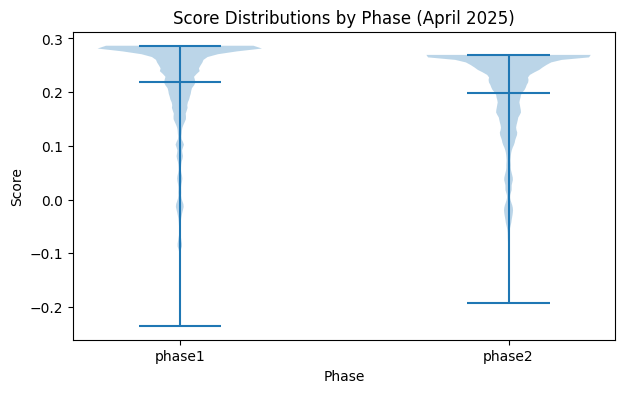

In [14]:
# 2) Violin plot of scores by phase (combining labels within a phase)
# Query raw rows (phase, label, score) for plotting distributions
cypher_rows = r"""

MATCH (tx:Transaction)
WHERE tx.timestamp >= $startEpoch
  AND tx.timestamp <  $endEpoch

WITH tx,
     CASE WHEN tx.label IS NOT NULL AND tx.scoring IS NOT NULL
          THEN {phase:'phase1', label: tx.label, score: toFloat(tx.scoring)} END AS r1,
     CASE WHEN tx.label_v2 IS NOT NULL AND tx.scoring_v2 IS NOT NULL
          THEN {phase:'phase2', label: tx.label_v2, score: toFloat(tx.scoring_v2)} END AS r2
WITH [r1, r2] AS rows
UNWIND rows AS r
WITH r WHERE r IS NOT NULL
RETURN r.phase AS phase, r.label AS label, r.score AS score
"""
rows = run_query(cypher_rows, params={"startEpoch": START_EPOCH, "endEpoch": END_EPOCH})

phase_order = sorted(rows['phase'].unique().tolist()) if len(rows)>0 else []
data = [rows.loc[rows['phase']==p, 'score'].dropna().tolist() for p in phase_order]

if phase_order:
    plt.figure(figsize=(7,4))
    plt.violinplot(dataset=data, showmeans=True, showextrema=True, showmedians=False)
    plt.title("Score Distributions by Phase (April 2025)")
    plt.xlabel("Phase")
    plt.ylabel("Score")
    plt.xticks(range(1, len(phase_order)+1), phase_order)
    plt.show()
else:
    print("No score rows found for plotting violin plot.")

/tmp/ipykernel_1652030/3352714597.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['label=0 (normal)','label=1 (anomaly)'], showmeans=True)


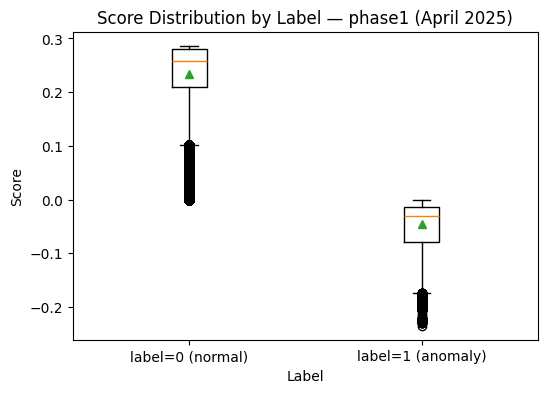

/tmp/ipykernel_1652030/3352714597.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['label=0 (normal)','label=1 (anomaly)'], showmeans=True)


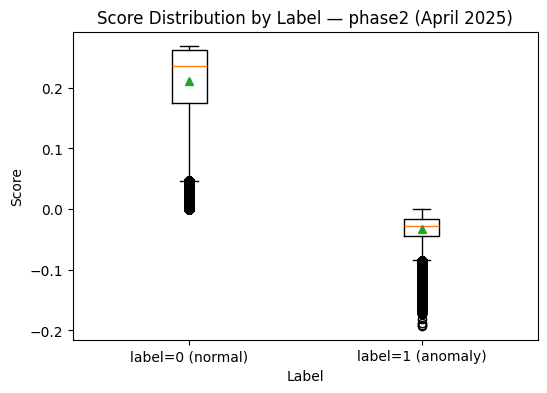

In [15]:
# 3) Optional: Per-label boxplots within each phase
if phase_order:
    for p in phase_order:
        subset = rows.loc[rows['phase']==p]
        data0 = subset.loc[subset['label']==0, 'score'].dropna().tolist()
        data1 = subset.loc[subset['label']==1, 'score'].dropna().tolist()

        plt.figure(figsize=(6,4))
        plt.boxplot([data0, data1], labels=['label=0 (normal)','label=1 (anomaly)'], showmeans=True)
        plt.title(f"Score Distribution by Label — {p} (April 2025)")
        plt.ylabel("Score")
        plt.xlabel("Label")
        plt.show()
else:
    print("Skipping per-label boxplots — no rows found.")

> **Note:** We intentionally did not import or use `scipy.stats` here to preserve the original logic. This notebook focuses on anomaly rate + descriptive stats. Add KS/other tests later if you want a statistical comparison cell.

In [8]:
# Close the driver when done
driver.close()